In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(7,5), 'font.size' : 10})
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
random_seed = 200

Using TensorFlow backend.


In [2]:
def parse_value(value):
    multiplicity_val = 1
    plus_val = 0
    if "M" in value:
        multiplicity_val = 1000000
        value = value.replace('M', '')
    elif "K" in value:
        multiplicity_val = 1000
        value = value.replace('K', '')
    value = value.replace('€', '')
    if '.' in value:
        plus_val = int(value[-1])*multiplicity_val/10
        value = value[:-2]
    value = int(value)
    value *= multiplicity_val
    value += plus_val
    value /= 1000000
    return value

df = pd.read_csv('data.csv', delimiter=',', index_col=0)
df['Value'] = df['Value'].apply(lambda value: parse_value(value))
df = df[['Overall', 'Potential', 'Age', 'Preferred Foot', 'ST', 'CM', 'CB', 'GKHandling', 'Value']]
df = df.dropna(axis = 0)
df['Preferred Foot'] = df['Preferred Foot'].apply(lambda s: 1.0 if s == 'Left' else 0.0)
df.head()

,Overall,Potential,Age,Preferred Foot,ST,CM,CB,GKHandling,Value
0,94,94,31,1.0,88.0,84.0,47.0,11.0,110.5
1,94,94,33,0.0,91.0,81.0,53.0,11.0,77.0
2,92,93,26,0.0,84.0,81.0,47.0,9.0,118.5
3,91,93,27,0.0,17.0,17.0,17.0,85.0,72.0
4,91,92,27,0.0,82.0,87.0,66.0,13.0,102.0


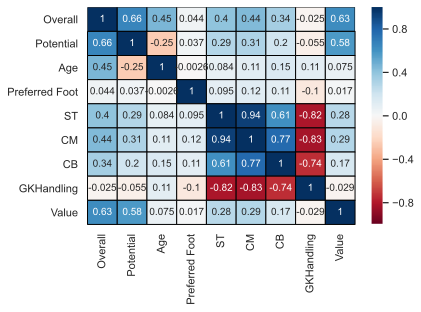

In [3]:
_ = sns.heatmap(df.corr(), cmap="RdBu", linecolor='black', linewidths = 1, vmin = -1, vmax = 1, annot = True)

In [ ]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = df.sample(frac=train_precent, random_state=random_seed)
test_data = df.drop(train_data.index)
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,Overall,Potential,Age,Preferred Foot,ST,CM,CB,GKHandling,Value
15071,-0.904806,0.435196,-1.097529,-0.549159,-0.809340,-0.832680,0.465039,-0.434917,-0.353923
12113,-0.471371,-1.357195,2.315680,-0.549159,-0.623822,-0.212099,0.640745,-0.016929,-0.420077
15990,-1.193762,-0.379527,-1.097529,-0.549159,-2.602687,-2.632365,-2.346255,2.490996,-0.398908
925,1.551326,1.086975,0.182424,1.820842,1.355043,0.842888,-0.472059,-0.315492,1.423430
9730,-0.037936,-0.868361,2.315680,-0.549159,0.612969,0.470539,0.172196,-0.614054,-0.390087


In [ ]:
y_label='Value'
train_x = normalized_train_data.drop(y_label, axis = 1)
train_y = normalized_train_data[y_label]
test_x = normalized_test_data.drop(y_label, axis = 1)
test_y = normalized_test_data[y_label]

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 400


def show_history(history):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['log_loss_1'] = np.log(history_df['loss'] + 1)
    sns.lineplot(data = history_df, y='log_loss_1', x='epoch')
    plt.gca().set_ylim(bottom=0)

def nn_mse(X,y, test_X, test_y):
    inputs_len = len(X.columns)
    input1 = Input(shape=(inputs_len,))
    hidden1 = Dense(inputs_len, activation='relu')(input1)
    hidden2 = Dense(inputs_len, activation='relu')(hidden1)
    out1 = Dense(1)(hidden2)
    model = Model(inputs=input1, outputs=out1)
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X, y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
    show_history(history)
    predicted = model.predict(X).flatten()
    expected = y
    train_NN_res = mean_squared_error(expected, predicted)
    predicted = model.predict(test_X).flatten()
    expected = test_y
    test_NN_res = mean_squared_error(expected, predicted)
    return train_NN_res, test_NN_res
train_NN_res, test_NN_res = nn_mse(train_x,train_y, test_x, test_y)


....................................................................................................
....................................................................................................
.............................

In [ ]:
def fit_predict_mse_test(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(test_X)
    return mean_squared_error(expected, test_Y)
def fit_predict_mse_train(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(train_X)
    return mean_squared_error(expected, train_Y)

In [ ]:
results_df = pd.DataFrame(columns=['Classifier', 'Test MSE'])
def predict_and_add_to_df(data_frame, name, regressor):
    return data_frame.append({'Classifier': name, 'Test MSE': fit_predict_mse_test(regressor, train_x, train_y, test_x, test_y)}, ignore_index = True)
    
#results_df = results_df.append({'Classifier': 'NN', 'MSE': nn_mse(X,y)}, ignore_index = True)
results_df = predict_and_add_to_df(results_df, 'KNN5', KNeighborsRegressor(5))
results_df = predict_and_add_to_df(results_df, 'KNN7', KNeighborsRegressor(7))
results_df = predict_and_add_to_df(results_df, 'KNN9', KNeighborsRegressor(9))
results_df = predict_and_add_to_df(results_df, 'Linear', LinearRegression())
results_df = predict_and_add_to_df(results_df, 'SVM', SVR())
results_df = predict_and_add_to_df(results_df, 'DTree2', DecisionTreeRegressor(max_depth = 2))
results_df = predict_and_add_to_df(results_df, 'DTree3', DecisionTreeRegressor(max_depth = 3))
results_df = predict_and_add_to_df(results_df, 'DTree4', DecisionTreeRegressor(max_depth = 4))
results_df = predict_and_add_to_df(results_df, 'DTree5', DecisionTreeRegressor(max_depth = 5))
results_df = results_df.sort_values(by = 'Test MSE').reset_index().drop(columns=['index'])

# Test Set

In [ ]:
results_df_train = pd.DataFrame(columns=['Classifier', 'Train MSE'])
def predict_and_add_to_df_train(data_frame, name, regressor):
    return data_frame.append({'Classifier': name, 'Train MSE': fit_predict_mse_train(regressor, train_x, train_y, test_x, test_y)}, ignore_index = True)
    
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN5', KNeighborsRegressor(5))
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN7', KNeighborsRegressor(7))
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN9', KNeighborsRegressor(9))
results_df_train = predict_and_add_to_df_train(results_df_train, 'Linear', LinearRegression())
results_df_train = predict_and_add_to_df_train(results_df_train, 'SVM', SVR())
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree2', DecisionTreeRegressor(max_depth = 2))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree3', DecisionTreeRegressor(max_depth = 3))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree4', DecisionTreeRegressor(max_depth = 4))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree5', DecisionTreeRegressor(max_depth = 5))
results_df_train = results_df_train.sort_values(by = 'Train MSE').reset_index().drop(columns=['index'])

#  Train Set

In [ ]:
results_df['Train MSE'] = results_df_train['Train MSE']
melted_df = results_df.melt(id_vars=['Classifier'], value_vars=['Test MSE', 'Train MSE'])
melted_df.rename(columns={'variable': 'Data-Set', 'value': 'MSE'}, inplace=True)
melted_df = melted_df.append({'Classifier' : 'NN' , 'Data-Set' : 'Test MSE', 'MSE' : test_NN_res} , ignore_index=True)
melted_df = melted_df.append({'Classifier' : 'NN' , 'Data-Set' : 'Train MSE', 'MSE' : train_NN_res} , ignore_index=True)
melted_df = melted_df.sort_values(['MSE'])
melted_df

In [ ]:
barplot = sns.barplot(data = melted_df, x = 'Classifier', y = 'MSE', hue = 'Data-Set', palette="Reds")
_ = barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30)